In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

print(tf.__version__)

1.13.1


In [2]:
# here we download the imbd review dataset with each review already being represented as a map to a dictionary of words
# the number 10,000 just says, only keep the 10k most used words. (keeps out data managment small) 
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)



In [12]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))
print("Test entries: {} ".format(len(test_data)))

Training entries: 25000, labels: 25000
Test entries: 25000 


In [10]:
print("encoded review: \n",train_data[6])
# each of these numbers represents an indecy into our dictionary of 10k words.
print("decoded review: \n",decode_review(train_data[6]))

encoded review: 
 [1, 6740, 365, 1234, 5, 1156, 354, 11, 14, 5327, 6638, 7, 1016, 2, 5940, 356, 44, 4, 1349, 500, 746, 5, 200, 4, 4132, 11, 2, 9363, 1117, 1831, 7485, 5, 4831, 26, 6, 2, 4183, 17, 369, 37, 215, 1345, 143, 2, 5, 1838, 8, 1974, 15, 36, 119, 257, 85, 52, 486, 9, 6, 2, 8564, 63, 271, 6, 196, 96, 949, 4121, 4, 2, 7, 4, 2212, 2436, 819, 63, 47, 77, 7175, 180, 6, 227, 11, 94, 2494, 2, 13, 423, 4, 168, 7, 4, 22, 5, 89, 665, 71, 270, 56, 5, 13, 197, 12, 161, 5390, 99, 76, 23, 2, 7, 419, 665, 40, 91, 85, 108, 7, 4, 2084, 5, 4773, 81, 55, 52, 1901]
decoded review: 
 <START> lavish production values and solid performances in this straightforward adaption of jane <UNK> satirical classic about the marriage game within and between the classes in <UNK> 18th century england northam and paltrow are a <UNK> mixture as friends who must pass through <UNK> and lies to discover that they love each other good humor is a <UNK> virtue which goes a long way towards explaining the <UNK> of the age

In [4]:
# used to decode words for analysis
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])


    

In [7]:
# to encode words we would want to first preprocess by making all strings lowercase 
# make the first index 0, itterat through getting the value for the word key, and if not found, mark 2. then add padding up to
# 256 characters with zeros

def encode_review(text):
    text = text.split()
    arr = np.zeros((256,),dtype=int)
    arr[0] = 1
    for i in range(0,len(text)):
        arr[i+1] = word_index.get(text[i].lower(),2)
    return arr
    

In [10]:
# so not every review is the same length but we need all tensors to be the same size to feed into our NN
# because of this we will pad the tensors to all be the same size. Luckily keras helps us with that
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

In [11]:
# so now all of our data is of the same length (256)
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [12]:
# now its time to build our NN. Remeber that our output maps to either a 1 or 0 for a positive or negative review respectively
# we define a variable to keep track of our max stored words
vocab_size = 10000
model = keras.Sequential()
# the first layer will take in the vocabulary and learn the embeddings for each word
model.add(keras.layers.Embedding(vocab_size,16))
model.add(keras.layers.GlobalAveragePooling1D())
# the global pooling will map to a 16d fully connected layer
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
# sigmoid will squash our result to be between a 0 and 1
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [13]:
# sense our output is binary it is best to use a binary_crossentory loss function
# adam is just a popular optimizer so why not use it
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [14]:
# while training we will want to check the progress of the model using data it hasnt seen before
# so we use a validation set to do this. We will take examples out of our taining set to hold for validaiton

x_val = train_data[:10000]  # takes the first 10k
partial_x_train = train_data[10000:]  # creates the new training set

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [15]:
# we chose 10 epochs (10 itterations over the entire training set) while using the 10k validation datapoints to validate
# we use a minibatch of 512 samples
history = model.fit(partial_x_train,partial_y_train,epochs=10,batch_size=512, validation_data=(x_val,y_val), verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
15000/15000 [==============================] - 1s 73us/sample - loss: 0.6922 - acc: 0.5173 - val_loss: 0.6908 - val_acc: 0.5644
Epoch 2/10
15000/15000 [==============================] - 1s 34us/sample - loss: 0.6872 - acc: 0.6737 - val_loss: 0.6832 - val_acc: 0.6789
Epoch 3/10
15000/15000 [==============================] - 1s 40us/sample - loss: 0.6739 - acc: 0.7288 - val_loss: 0.6651 - val_acc: 0.7515
Epoch 4/10
15000/15000 [==============================] - 1s 36us/sample - loss: 0.6484 - acc: 0.7551 - val_loss: 0.6357 - val_acc: 0.7637
Epoch 5/10
15000/15000 [==============================] - 1s 35us/sample - loss: 0.6108 - acc: 0.7910 - val_loss: 0.5966 - val_acc: 0.7881
Epoch 6/10
15000/15000 [==============================] - 1s 35us/sample - loss: 0.5640 - acc: 0.8144 - val_loss: 0.5522 - val_acc: 0.8060
Epoch 7/10
15000/15000 [==============================] - 1s 36us/sa

In [16]:
# with just 10 epochs on a fairly naive model we acheive 84% accuracy on our test data of 25k eamples, AWESOME
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 33us/sample - loss: 0.4055 - acc: 0.8478
[0.4055185865592957, 0.84776]


In [19]:
# an important part of data science is plotting model metrics to better understand the model
# lucky for us, keras returns a history of the model when we call fit on it, so lets sue that

history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


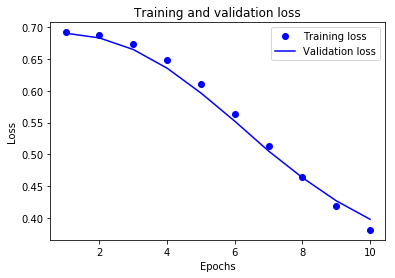

In [18]:
# so our history is a dictionary that holds the loss, acc, val_loss, and val_acc over the model
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

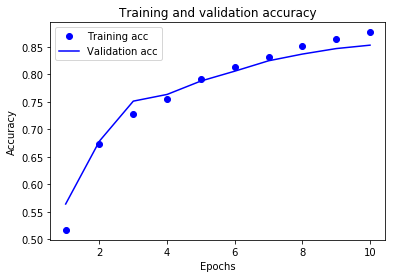

In [20]:
#plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [164]:
# now in order to actually predict we would need to take in text, encode it, preprocess it, pass it to our model,
# interpret the output and see what going 
def classify_review(text):
    code = encode_review(text)
    code = np.array([code])
    prediction = model.predict(code)
    # decided on .54 not super rigourous, just worked in practice
    if(prediction < 0.54):
        return "negative"
    else:
        return "positive"
    

In [170]:
classify_review('this was the worst movie ever')

'negative'

In [171]:
classify_review('i loved it!')

'positive'